# many to many bi-directional

In [1]:
# setup
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pprint import pprint
%matplotlib inline

In [2]:
# example data
sentences = [['I', 'feel', 'hungry'],
     ['tensorflow', 'is', 'very', 'difficult'],
     ['tensorflow', 'is', 'a', 'framework', 'for', 'deep', 'learning'],
     ['tensorflow', 'is', 'very', 'fast', 'changing']]
pos = [['pronoun', 'verb', 'adjective'],
     ['noun', 'verb', 'adverb', 'adjective'],
     ['noun', 'verb', 'determiner', 'noun', 'preposition', 'adjective', 'noun'],
     ['noun', 'verb', 'adverb', 'adjective', 'verb']]

In [3]:
# creating a token dictionary for word
word_list = sum(sentences, [])
word_list = sorted(set(word_list))
word_list = ['<pad>'] + word_list
word2idx = {word : idx for idx, word in enumerate(word_list)}
idx2word = {idx : word for idx, word in enumerate(word_list)}

print(word2idx)
print(idx2word)
print(len(idx2word))

{'<pad>': 0, 'I': 1, 'a': 2, 'changing': 3, 'deep': 4, 'difficult': 5, 'fast': 6, 'feel': 7, 'for': 8, 'framework': 9, 'hungry': 10, 'is': 11, 'learning': 12, 'tensorflow': 13, 'very': 14}
{0: '<pad>', 1: 'I', 2: 'a', 3: 'changing', 4: 'deep', 5: 'difficult', 6: 'fast', 7: 'feel', 8: 'for', 9: 'framework', 10: 'hungry', 11: 'is', 12: 'learning', 13: 'tensorflow', 14: 'very'}
15


In [4]:
# creating a token dictionary for part of speech
pos_list = sum(pos, [])
pos_list = sorted(set(pos_list))
pos_list = ['<pad>'] + pos_list
pos2idx = {pos : idx for idx, pos in enumerate(pos_list)}
idx2pos = {idx : pos for idx, pos in enumerate(pos_list)}

print(pos2idx)
print(idx2pos)
print(len(pos2idx))

{'<pad>': 0, 'adjective': 1, 'adverb': 2, 'determiner': 3, 'noun': 4, 'preposition': 5, 'pronoun': 6, 'verb': 7}
{0: '<pad>', 1: 'adjective', 2: 'adverb', 3: 'determiner', 4: 'noun', 5: 'preposition', 6: 'pronoun', 7: 'verb'}
8


In [5]:
# converting sequence of tokens to sequence of indices
max_sequence = 10
x_data = list(map(lambda sentence : [word2idx.get(token) for token in sentence], sentences))
y_data = list(map(lambda sentence : [pos2idx.get(token) for token in sentence], pos))

# padding the sequence of indices
x_data = pad_sequences(sequences = x_data, maxlen = max_sequence, padding='post')
x_data_mask = ((x_data != 0) * 1).astype(np.float32)
x_data_len = list(map(lambda sentence : len(sentence), sentences))

y_data = pad_sequences(sequences = y_data, maxlen = max_sequence, padding='post')

# checking data
print(x_data, x_data_len)
print(x_data_mask)
print(y_data)

[[ 1  7 10  0  0  0  0  0  0  0]
 [13 11 14  5  0  0  0  0  0  0]
 [13 11  2  9  8  4 12  0  0  0]
 [13 11 14  6  3  0  0  0  0  0]] [3, 4, 7, 5]
[[1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]]
[[6 7 1 0 0 0 0 0 0 0]
 [4 7 2 1 0 0 0 0 0 0]
 [4 7 3 4 5 1 4 0 0 0]
 [4 7 2 1 7 0 0 0 0 0]]


In [6]:
# creating bidirectional rnn for "many to many" sequence tagging
num_classes = len(pos2idx)
hidden_dim = 10

input_dim = len(word2idx)
output_dim = len(word2idx)
one_hot = np.eye(len(word2idx))

model = Sequential()
model.add(layers.InputLayer(input_shape=(max_sequence,)))
# embedding layer는 토큰을 one-hot 으로 처리하게 함.
model.add(layers.Embedding(input_dim=input_dim, output_dim=output_dim, mask_zero=True,
                                 trainable=False, input_length=max_sequence,
                                 embeddings_initializer=keras.initializers.Constant(one_hot)))
# 기존 simplernn을 bidirectional을 감사면 됨.
model.add(layers.Bidirectional(keras.layers.SimpleRNN(units=hidden_dim, return_sequences=True)))
model.add(layers.TimeDistributed(keras.layers.Dense(units=num_classes)))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 15)            225       
                                                                 
 bidirectional (Bidirection  (None, 10, 20)            520       
 al)                                                             
                                                                 
 time_distributed (TimeDist  (None, 10, 8)             168       
 ributed)                                                        
                                                                 
Total params: 913 (3.57 KB)
Trainable params: 688 (2.69 KB)
Non-trainable params: 225 (900.00 Byte)
_________________________________________________________________


In [8]:
# creating loss function
def loss_fn(model, x, y, x_len, max_sequence):
    masking = tf.sequence_mask(x_len, maxlen=max_sequence, dtype=tf.float32)
    valid_time_step = tf.cast(x_len,dtype=tf.float32)
    sequence_loss = tf.keras.losses.sparse_categorical_crossentropy(
        y_true=y, y_pred=model(x), from_logits=True) * masking
    sequence_loss = tf.reduce_sum(sequence_loss, axis=-1) / valid_time_step
    sequence_loss = tf.reduce_mean(sequence_loss)
    return sequence_loss

# creating and optimizer
lr = 0.1
epochs = 30
batch_size = 2
opt = tf.keras.optimizers.Adam(learning_rate = lr)

In [9]:
# generating data pipeline
tr_dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data, x_data_len))
tr_dataset = tr_dataset.shuffle(buffer_size=4)
tr_dataset = tr_dataset.batch(batch_size = 2)

print(tr_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 10), dtype=tf.int32, name=None), TensorSpec(shape=(None, 10), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [10]:
# training
tr_loss_hist = []

for epoch in range(epochs):
    avg_tr_loss = 0
    tr_step = 0

    for x_mb, y_mb, x_mb_len in tr_dataset:
        with tf.GradientTape() as tape:
            tr_loss = loss_fn(model, x=x_mb, y=y_mb, x_len=x_mb_len, max_sequence=max_sequence)
        grads = tape.gradient(target=tr_loss, sources=model.variables)
        opt.apply_gradients(grads_and_vars=zip(grads, model.variables))
        avg_tr_loss += tr_loss
        tr_step += 1
    else:
        avg_tr_loss /= tr_step
        tr_loss_hist.append(avg_tr_loss)

    if (epoch + 1) % 5 == 0:
        print('epoch : {:3}, tr_loss : {:.3f}'.format(epoch + 1, avg_tr_loss))

epoch :   5, tr_loss : 0.014
epoch :  10, tr_loss : 0.001
epoch :  15, tr_loss : 0.000
epoch :  20, tr_loss : 0.000
epoch :  25, tr_loss : 0.000
epoch :  30, tr_loss : 0.000


In [11]:
yhat = model.predict(x_data)
yhat = np.argmax(yhat, axis=-1) * x_data_mask

pprint(list(map(lambda row : [idx2pos.get(elm) for elm in row],yhat.astype(np.int32).tolist())), width = 120)
pprint(pos)

1/1 [==============================] - 0s 349ms/step
[['pronoun', 'verb', 'adjective', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'],
 ['noun', 'verb', 'adverb', 'adjective', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'],
 ['noun', 'verb', 'determiner', 'noun', 'preposition', 'adjective', 'noun', '<pad>', '<pad>', '<pad>'],
 ['noun', 'verb', 'adverb', 'adjective', 'verb', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']]
[['pronoun', 'verb', 'adjective'],
 ['noun', 'verb', 'adverb', 'adjective'],
 ['noun', 'verb', 'determiner', 'noun', 'preposition', 'adjective', 'noun'],
 ['noun', 'verb', 'adverb', 'adjective', 'verb']]


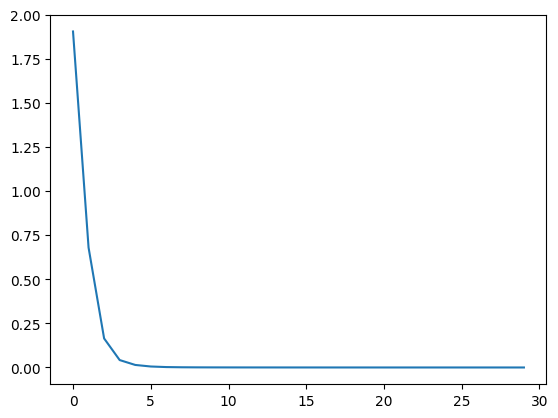

In [12]:
plt.plot(tr_loss_hist)